In [5]:
import numpy as np
import corrct as cct
import scipy as sp
import matplotlib.pyplot as plt

from numpy.typing import NDArray
from collections.abc import Sequence
import torch
import astra
from glob import glob
import tifffile
from tqdm import tqdm
from src import _PATH_DATA

# %reload_ext autoreload
# %autoreload 2

# %matplotlib widget

In [6]:
#define plenoptic projector in astra:
class ProjectorPlenoptic(cct.operators.ProjectorOperator):
    """Plenoptic imaging projector."""

    def __init__(
        self, src_vu_pix: NDArray, vol_z0_pix: float, vol_shape_yxz: Sequence[int] | NDArray, angles: NDArray = np.array([0]), super_sampling: int = 2, detector_z: float = 0.0, pixel_size_x: float = 1.0,pixel_size_y: float = 1.0, angle: bool = False
    ):
        """Initialize plenoptic projector.

        Parameters
        ----------
        src_vu_pix : NDArray
            Source positions in VU, as <2 x (Nv x Nu)>
        vol_z0_pix : float
            Detector-sample distance
        vol_shape_yxz : Sequence[int]
            Volume shape in pixels
        super_sampling : int
            The super-sampling factor, by default 1.

        Examples
        --------
        src_vu_pix = np.meshgrid(sources_v, sources_u, indexing="ij")
        src_vu_pix = np.stack([c.flatten() for c in src_vu_pix], axis=0)
        """
        self.super_sampling = super_sampling
        self.proj_id = None

        self.vol_geom = astra.create_vol_geom(*vol_shape_yxz)

        num_imgs = src_vu_pix.shape[-1]

        if angle:
            src_vu2xyz = np.swapaxes(np.stack([np.zeros(16),-vol_z0_pix*np.sin(angles),-vol_z0_pix*np.cos(angles)]),0,1)
    
            det_xyz = np.swapaxes(np.stack([np.zeros(16),detector_z*np.sin(angles),detector_z*np.cos(angles)]),0,1)

        else:
            src_vu2xyz = np.empty((num_imgs, 3))
            src_vu2xyz[:, 0] = src_vu_pix[0]
            src_vu2xyz[:, 1] = src_vu_pix[1]
            src_vu2xyz[:, 2] = -vol_z0_pix
            det_xyz = np.zeros_like(src_vu2xyz)
            det_xyz[:, 0] = -src_vu_pix[0]
            det_xyz[:, 1] = -src_vu_pix[1]
            det_xyz[:, 2] = detector_z
            
        dir_x = np.zeros_like(src_vu2xyz)
        dir_x[:, 0] = pixel_size_x
        dir_y = np.zeros_like(src_vu2xyz)
        dir_y[:, 1] = pixel_size_y 
        det_geometry = np.hstack([src_vu2xyz, det_xyz, dir_x, dir_y])
        print("det geometry vector(( srcX, srcY, srcZ, dX, dY, dZ, uX, uY, uZ, vX, vY, vZ )):")
        print(det_geometry[0])
        self.proj_geom = astra.create_proj_geom("cone_vec", vol_shape_yxz[0], vol_shape_yxz[1], det_geometry)

        self.prj_shape = [vol_shape_yxz[0], num_imgs, vol_shape_yxz[1]]  # Y(V*U)X
        self.vol_shape = [vol_shape_yxz[-1], vol_shape_yxz[-3], vol_shape_yxz[-2]]  # ZYX
        super().__init__()

    def __enter__(self):
        """Initialize the with statement block."""
        self._make_ready()
        return self

    def __exit__(self, *args):
        """De-initialize the with statement block."""
        self._dispose()

    def _make_ready(self):
        """Initialize the ASTRA projectors."""
        if self.proj_id is None:
            voxel_sampling = int(self.super_sampling)
            pixel_sampling = int(self.super_sampling)
            opts = {"VoxelSuperSampling": voxel_sampling, "DetectorSuperSampling": pixel_sampling}

            self.proj_id = astra.create_projector("cuda3d", self.proj_geom, self.vol_geom, opts)

    def _dispose(self) -> None:
        """De-initialize the ASTRA projectors."""
        astra.projector.delete(self.proj_id)
        self.proj_id = None

    def _check_data(self, x: NDArray, expected_shape: Sequence[int] | NDArray[np.integer]) -> NDArray:
        if x.dtype != np.float32:
            x = x.astype(np.float32)
        if not x.flags["C_CONTIGUOUS"]:
            x = np.ascontiguousarray(x)
        try:
            return x.reshape(np.array(expected_shape, ndmin=1))
        except ValueError:
            print(f"Could not reshape input data of shape={x.shape} into expected shape={expected_shape}")
            raise

    def fp(self, vol: NDArray):
        """Forward-project a volume to a stack of images.

        Parameters
        ----------
        vol : NDArray
            The volume.

        Returns
        -------
        NDArray
            The forward-projected stack of images.
        """
        self._make_ready()

        prj = np.zeros(self.prj_shape, dtype=np.float32)
        vol = self._check_data(vol, self.vol_shape)
        astra.experimental.direct_FP3D(self.proj_id, vol, prj)
        return prj.reshape(self.prj_shape)

    def bp(self, prj: NDArray):
        """Back-project a stack of images to a volume.

        Parameters
        ----------
        prj : NDArray
            The stack of images.

        Returns
        -------
        NDArray
            The back-projected volume.
        """
        self._make_ready()

        prj = self._check_data(prj, self.prj_shape)
        vol = np.zeros(self.vol_shape, dtype=np.float32)
        astra.experimental.direct_BP3D(self.proj_id, vol, prj)
        return vol#vol.reshape(self.prj_shape)

In [7]:
# sourec points in multiple of pixel unit:
sources_v = np.linspace(-5, 5, 4) * 2e1
sources_u = np.linspace(-5, 5, 4) * 2e1
src_vu_pix = np.meshgrid(sources_v, sources_u, indexing="ij")
src_vu_pix = np.stack([c.flatten() for c in src_vu_pix], axis=0)

In [8]:
#here we are assuming the phantom volume is 1 um voxel size.
detector_distance = 100e4 #deafult 1, if voxel size = 1um, then 1m = 1e6.
sample_source_distance = 3e4 #default 1500, if voxel size = 1um, 3cm = 3e4
pixel_size_x = 55.0 #default 1, 55um pixel size
pixel_size_y = 55.0 #default 1, 55um pixel size
#here we call the forward
angles = np.linspace(0,np.pi,16)

In [9]:
vol_shape_yxz = np.array([300,300,300])

projector_data = dict(src_vu_pix=np.array(src_vu_pix), vol_z0_pix=sample_source_distance, vol_shape_yxz=vol_shape_yxz, angles=angles, super_sampling=2,detector_z=detector_distance,pixel_size_x=pixel_size_x,pixel_size_y=pixel_size_y,angle=False)
prj = ProjectorPlenoptic(**projector_data)

files = glob(f'{_PATH_DATA}/synthetic_fibers_plenoptic/*.tif')
for file in tqdm(files):
    vol = tifffile.imread(file)
    vol -= vol.min()
    vol = vol/vol.max()
    ph_imgs = prj(vol)
    ph_imgs = np.swapaxes(ph_imgs,1,0)
    ph_imgs = np.swapaxes(ph_imgs,1,2)
    ph_imgs = 1 - np.exp(-ph_imgs/((ph_imgs.shape[1]+1)/2))
    
    np.save(f"{file[:-4]}_projections.npy",ph_imgs)
    np.save(f"{file[:-4]}_positions.npy",prj.proj_geom['Vectors'])

det geometry vector(( srcX, srcY, srcZ, dX, dY, dZ, uX, uY, uZ, vX, vY, vZ )):
[-1.0e+02 -1.0e+02 -3.0e+04  1.0e+02  1.0e+02  1.0e+06  5.5e+01  0.0e+00
  0.0e+00  0.0e+00  5.5e+01  0.0e+00]


100%|█████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.02it/s]


In [10]:
vol_shape_yxz = np.array([300,300,300])

projector_data = dict(src_vu_pix=np.array(src_vu_pix), vol_z0_pix=sample_source_distance, vol_shape_yxz=vol_shape_yxz, angles=angles, super_sampling=2,detector_z=detector_distance,pixel_size_x=pixel_size_x,pixel_size_y=pixel_size_y,angle=True)
prj = ProjectorPlenoptic(**projector_data)

files = glob(f'{_PATH_DATA}/synthetic_fibers_angle/*.tif')
for file in tqdm(files):
    vol = tifffile.imread(file)
    vol -= vol.min()
    vol = vol/vol.max()
    ph_imgs = prj(vol)
    ph_imgs = np.swapaxes(ph_imgs,1,0)
    ph_imgs = np.swapaxes(ph_imgs,1,2)
    ph_imgs = 1 - np.exp(-ph_imgs/((ph_imgs.shape[1]+1)/2))
    
    np.save(f"{file[:-4]}_projections.npy",ph_imgs)
    np.save(f"{file[:-4]}_positions.npy",prj.proj_geom['Vectors'])

det geometry vector(( srcX, srcY, srcZ, dX, dY, dZ, uX, uY, uZ, vX, vY, vZ )):
[ 0.0e+00 -0.0e+00 -3.0e+04  0.0e+00  0.0e+00  1.0e+06  5.5e+01  0.0e+00
  0.0e+00  0.0e+00  5.5e+01  0.0e+00]


100%|█████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.57it/s]


In [11]:
vol_shape_yxz = np.array([250,250,250])

projector_data = dict(src_vu_pix=np.array(src_vu_pix), vol_z0_pix=sample_source_distance, vol_shape_yxz=vol_shape_yxz, angles=angles, super_sampling=2,detector_z=detector_distance,pixel_size_x=pixel_size_x,pixel_size_y=pixel_size_y,angle=False)
prj = ProjectorPlenoptic(**projector_data)

files = glob(f'{_PATH_DATA}/real_fibers_plenoptic/*.tif')
for file in tqdm(files):
    vol = tifffile.imread(file)
    vol -= vol.min()
    vol = vol/vol.max()
    ph_imgs = prj(vol)
    ph_imgs = np.swapaxes(ph_imgs,1,0)
    ph_imgs = np.swapaxes(ph_imgs,1,2)
    ph_imgs = 1 - np.exp(-ph_imgs/((ph_imgs.shape[1]+1)/2))
    
    np.save(f"{file[:-4]}_projections.npy",ph_imgs)
    np.save(f"{file[:-4]}_positions.npy",prj.proj_geom['Vectors'])

det geometry vector(( srcX, srcY, srcZ, dX, dY, dZ, uX, uY, uZ, vX, vY, vZ )):
[-1.0e+02 -1.0e+02 -3.0e+04  1.0e+02  1.0e+02  1.0e+06  5.5e+01  0.0e+00
  0.0e+00  0.0e+00  5.5e+01  0.0e+00]


100%|█████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.13it/s]


In [12]:
vol_shape_yxz = np.array([250,250,250])

projector_data = dict(src_vu_pix=np.array(src_vu_pix), vol_z0_pix=sample_source_distance, vol_shape_yxz=vol_shape_yxz, angles=angles, super_sampling=2,detector_z=detector_distance,pixel_size_x=pixel_size_x,pixel_size_y=pixel_size_y,angle=True)
prj = ProjectorPlenoptic(**projector_data)

files = glob(f'{_PATH_DATA}/real_fibers_angle/*.tif')
for file in tqdm(files):
    vol = tifffile.imread(file)
    vol -= vol.min()
    vol = vol/vol.max()
    ph_imgs = prj(vol)
    ph_imgs = np.swapaxes(ph_imgs,1,0)
    ph_imgs = np.swapaxes(ph_imgs,1,2)
    ph_imgs = 1 - np.exp(-ph_imgs/((ph_imgs.shape[1]+1)/2))
    
    np.save(f"{file[:-4]}_projections.npy",ph_imgs)
    np.save(f"{file[:-4]}_positions.npy",prj.proj_geom['Vectors'])

det geometry vector(( srcX, srcY, srcZ, dX, dY, dZ, uX, uY, uZ, vX, vY, vZ )):
[ 0.0e+00 -0.0e+00 -3.0e+04  0.0e+00  0.0e+00  1.0e+06  5.5e+01  0.0e+00
  0.0e+00  0.0e+00  5.5e+01  0.0e+00]


100%|█████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.39it/s]


In [10]:
ph_imgs = np.load(f"{file[:-4]}_projections.npy")

vol shape (300, 300, 300)
number of pinhole images 16
pinhole imgaes shape (300, 16, 300)


<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

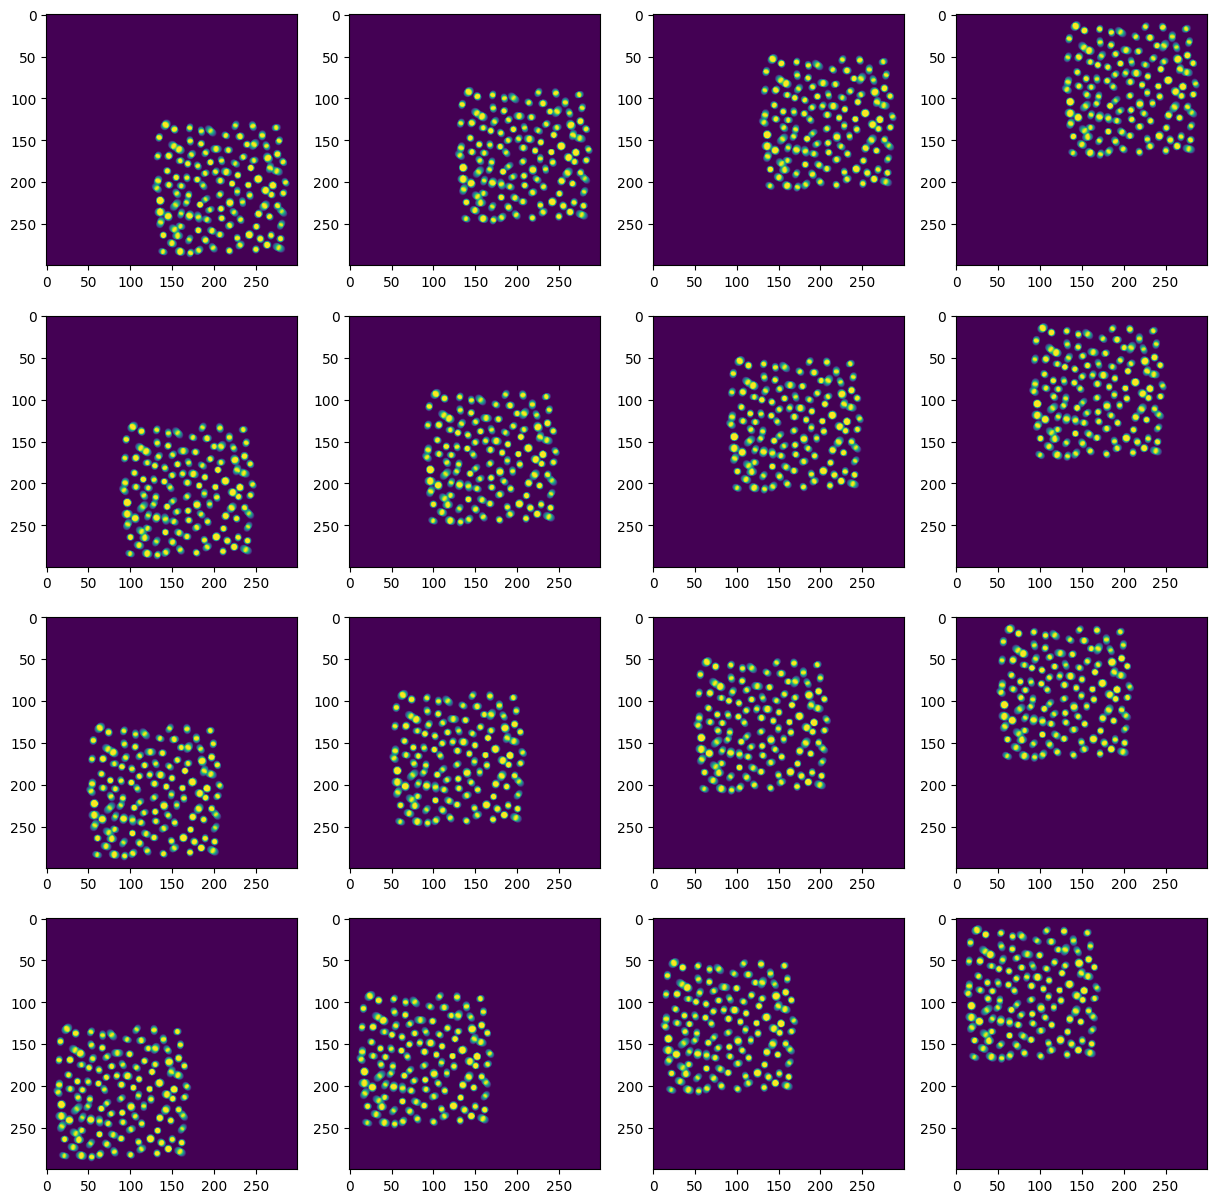

In [11]:
n_phi = len(sources_v)*len(sources_u)
print("vol shape",vol.shape)
print("number of pinhole images", n_phi)
print("pinhole imgaes shape",ph_imgs.shape)
#dim 1 is the phi.
plt.figure(figsize=[15,15])
for n1 in range(n_phi):
    plt.subplot(len(sources_u),len(sources_v),n1+1)
    plt.imshow(ph_imgs[:,n1,:])
plt.close